In [39]:
import os
import numpy as np
from Brats2020_Segmentation_Data_Generator import imageLoader
import tensorflow as tf
import keras
from matplotlib import pyplot as plt
import glob
import random
from keras import backend as K
from matplotlib import pyplot as plt
import random


In [40]:
def conv_block(inputs, filters, kernel_size=3):
    x = inputs
    for i in range(2):
        x = tf.keras.layers.Conv3D(filters, kernel_size, kernel_initializer="he_normal",
                                   padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)  # Apply BatchNorm
        x = tf.keras.layers.Activation("relu")(x)
    return x


def encoder_block(inputs, filters=16):
    f = conv_block(inputs, filters=filters)  # output for the concat
    p = tf.keras.layers.MaxPooling3D((2, 2, 2))(f)
    p = tf.keras.layers.Dropout(0.2)(p)
    return f, p


def encoder(inputs):
    filters = 16
    f1, p1 = encoder_block(inputs, filters)
    f2, p2 = encoder_block(p1, filters * 2)
    f3, p3 = encoder_block(p2, filters * 4)
    f4, p4 = encoder_block(p3, filters * 8)
    return p4, (f1, f2, f3, f4)


def bottleneck(inputs):
    bottle_neck = conv_block(inputs, 256)
    return bottle_neck


def decoder_block(inputs, conv_out, filters=128, kernel_size=3, strides=(2, 2, 2)):
    u = tf.keras.layers.Conv3DTranspose(filters, kernel_size, strides, padding="same")(inputs)
    cat = tf.keras.layers.concatenate([u, conv_out])
    cat = tf.keras.layers.Dropout(0.2)(cat)
    cat = conv_block(cat, filters, kernel_size)
    return cat


def decoder(inputs, convs, out_channels, filters=128):
    f1, f2, f3, f4 = convs

    c6 = decoder_block(inputs, f4, filters)
    c7 = decoder_block(c6, f3, filters // 2)
    c8 = decoder_block(c7, f2, filters // 4)
    c9 = decoder_block(c8, f1, filters // 8)

    outputs = tf.keras.layers.Conv3D(out_channels, 1, activation="softmax")(c9)
    return outputs


In [41]:
OUTPUT_CHANNELS=4
def unet():
    
    inputs= tf.keras.layers.Input(shape=(128, 128, 128, 3))
    #inputs= tf.keras.layers.Lambda(lambda x: x/255)(inputs)
    encoder_output, convs = encoder(inputs)
    bottle_neck= bottleneck(encoder_output)
    outputs= decoder(bottle_neck, convs, OUTPUT_CHANNELS)
    model= tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

model= unet()
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                28, 3)]                                                           
                                                                                                  
 conv3d_38 (Conv3D)             (None, 128, 128, 12  1312        ['input_3[0][0]']                
                                8, 16)                                                            
                                                                                                  
 batch_normalization_36 (BatchN  (None, 128, 128, 12  64         ['conv3d_38[0][0]']              
 ormalization)                  8, 16)                                                      

                                                                                                  
 activation_42 (Activation)     (None, 16, 16, 16,   0           ['batch_normalization_42[0][0]'] 
                                128)                                                              
                                                                                                  
 conv3d_45 (Conv3D)             (None, 16, 16, 16,   442496      ['activation_42[0][0]']          
                                128)                                                              
                                                                                                  
 batch_normalization_43 (BatchN  (None, 16, 16, 16,   512        ['conv3d_45[0][0]']              
 ormalization)                  128)                                                              
                                                                                                  
 activatio

                                64)                                                               
                                                                                                  
 batch_normalization_49 (BatchN  (None, 32, 32, 32,   256        ['conv3d_51[0][0]']              
 ormalization)                  64)                                                               
                                                                                                  
 activation_49 (Activation)     (None, 32, 32, 32,   0           ['batch_normalization_49[0][0]'] 
                                64)                                                               
                                                                                                  
 conv3d_transpose_10 (Conv3DTra  (None, 64, 64, 64,   55328      ['activation_49[0][0]']          
 nspose)                        32)                                                               
          

In [42]:
print(model.input_shape)
print(model.output_shape)

(None, 128, 128, 128, 3)
(None, 128, 128, 128, 4)


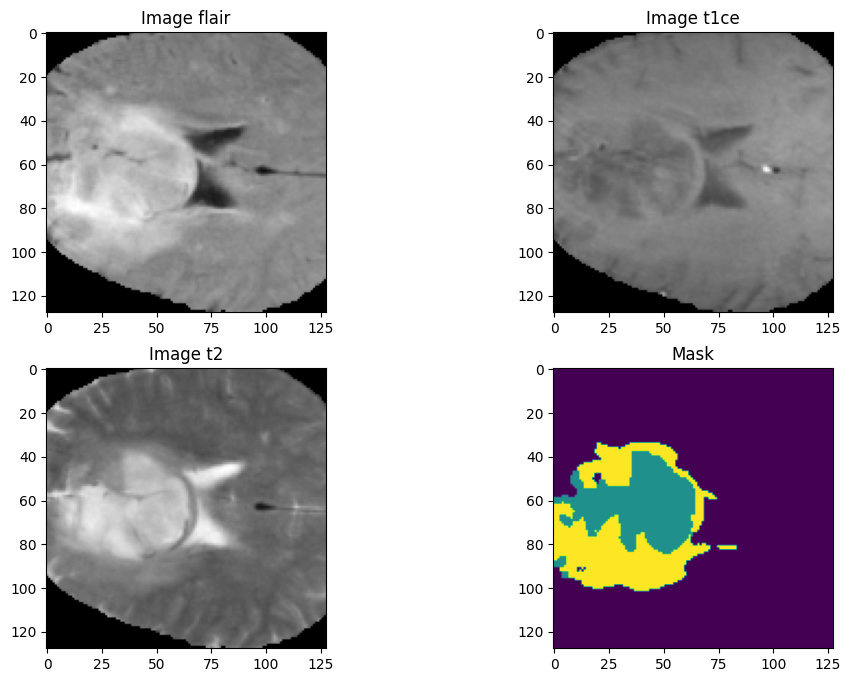

In [43]:
train_img_dir = "BraTS2020_TrainingData/input_data_128/train/images/"
train_mask_dir = "BraTS2020_TrainingData/input_data_128/train/masks/"

img_list = os.listdir(train_img_dir)
msk_list = os.listdir(train_mask_dir)

num_images = len(os.listdir(train_img_dir))

img_num = random.randint(0,num_images-1)
test_img = np.load(train_img_dir+img_list[img_num])
test_mask = np.load(train_mask_dir+msk_list[img_num])
test_mask = np.argmax(test_mask, axis=3)

n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

In [44]:
train_img_dir = "BraTS2020_TrainingData/input_data_128/train/images/"
train_mask_dir = "BraTS2020_TrainingData/input_data_128/train/masks/"

val_img_dir = "BraTS2020_TrainingData/input_data_128/val/images/"
val_mask_dir = "BraTS2020_TrainingData/input_data_128/val/masks/"

train_img_list=os.listdir(train_img_dir)
train_mask_list = os.listdir(train_mask_dir)

val_img_list=os.listdir(val_img_dir)
val_mask_list = os.listdir(val_mask_dir)

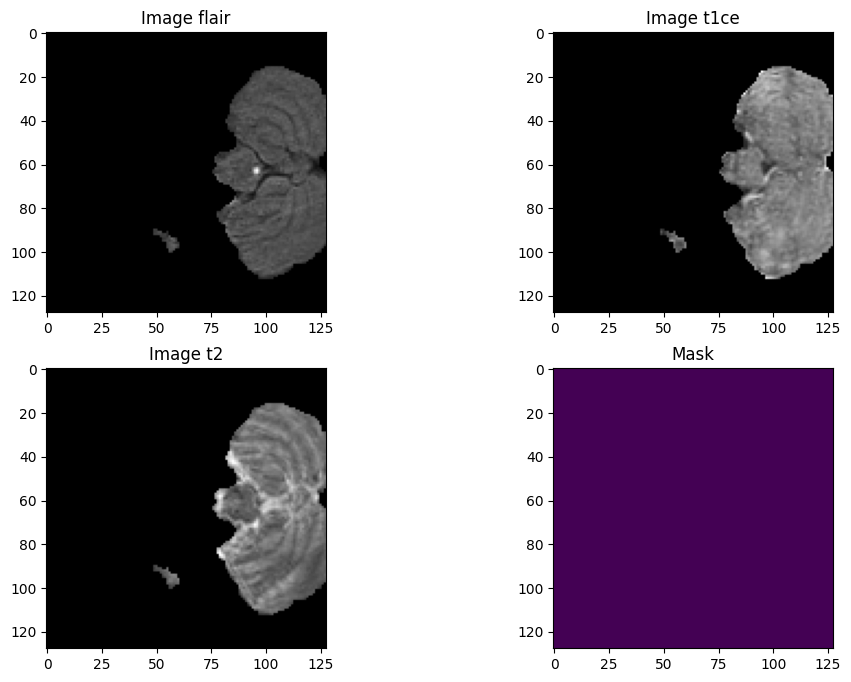

In [45]:
batch_size = 1

train_img_datagen = imageLoader(train_img_dir, train_img_list, 
                                train_mask_dir, train_mask_list, batch_size)

val_img_datagen = imageLoader(val_img_dir, val_img_list, 
                                val_mask_dir, val_mask_list, batch_size)

#Verify generator.... In python 3 next() is renamed as __next__()
img, msk = train_img_datagen.__next__()

img_num = random.randint(0,img.shape[0]-1)
test_img=img[img_num]
test_mask=msk[img_num]
test_mask=np.argmax(test_mask, axis=3)

n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

In [46]:
img.shape

(1, 128, 128, 128, 3)

In [47]:
msk.shape

(1, 128, 128, 128, 4)

In [48]:
def dice_coefficient(y_true, y_pred):
    smooth = 1.0
    flat_y_true = K.flatten(y_true)
    flat_y_pred = K.flatten(y_pred)
    
    intersection = K.sum(flat_y_true * flat_y_pred)
    union = K.sum(flat_y_true) + K.sum(flat_y_pred)
    
    dice_score = (2.0 * intersection + smooth) / (union + smooth)
    
    return dice_score

In [49]:
def tversky_loss(y_true, y_pred):
    alpha = 0.3
    beta  = 0.7
    
    ones = K.ones_like(y_true)
    p0 = y_pred      # proba that voxels are class i
    p1 = ones-y_pred # proba that voxels are not class i
    g0 = y_true
    g1 = ones-y_true
    
    num = K.sum(p0*g0, (0,1,2,3))
    den = num + alpha*K.sum(p0*g1,(0,1,2,3)) + beta*K.sum(p1*g0,(0,1,2,3))
    
    T = K.sum(num/den) # when summing over classes, T has dynamic range [0 Ncl]
    
    Ncl = K.cast(K.shape(y_true)[-1], 'float32')
    return Ncl-T

In [50]:
metrics = ['accuracy', dice_coefficient]

In [51]:

LR = 0.0001
optim = keras.optimizers.Adam(LR)

In [52]:
model.compile(optimizer = optim, loss=tversky_loss, metrics=metrics)

In [53]:
steps_per_epoch = len(train_img_list)//batch_size
val_steps_per_epoch = len(val_img_list)//batch_size

In [54]:
history=model.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=40,
          verbose=1,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
          )

Epoch 1/40
258/258 [==============================] - 208s 799ms/step - loss: 3.2190 - accuracy: 0.5311 - dice_coefficient: 0.4242 - val_loss: 3.0875 - val_accuracy: 0.6732 - val_dice_coefficient: 0.5017
Epoch 2/40
258/258 [==============================] - 208s 805ms/step - loss: 2.9457 - accuracy: 0.8410 - dice_coefficient: 0.5397 - val_loss: 3.0249 - val_accuracy: 0.7497 - val_dice_coefficient: 0.5204
Epoch 3/40
258/258 [==============================] - 207s 802ms/step - loss: 2.7556 - accuracy: 0.9274 - dice_coefficient: 0.6202 - val_loss: 2.8623 - val_accuracy: 0.8260 - val_dice_coefficient: 0.6003
Epoch 4/40
258/258 [==============================] - 206s 799ms/step - loss: 2.5682 - accuracy: 0.9457 - dice_coefficient: 0.6968 - val_loss: 2.7116 - val_accuracy: 0.8403 - val_dice_coefficient: 0.6718
Epoch 5/40
258/258 [==============================] - 206s 798ms/step - loss: 2.3790 - accuracy: 0.9536 - dice_coefficient: 0.7655 - val_loss: 2.5337 - val_accuracy: 0.8650 - val_dice_

In [55]:
model.save("brats_3d_40_epochs_v2.hdf5")

In [34]:
from keras.models import load_model


In [35]:
model = load_model('brats_3d_40_epochs_v2.hdf5', 
                      custom_objects={'tversky_loss': tversky_loss,
                                      'dice_coefficient':dice_coefficient})

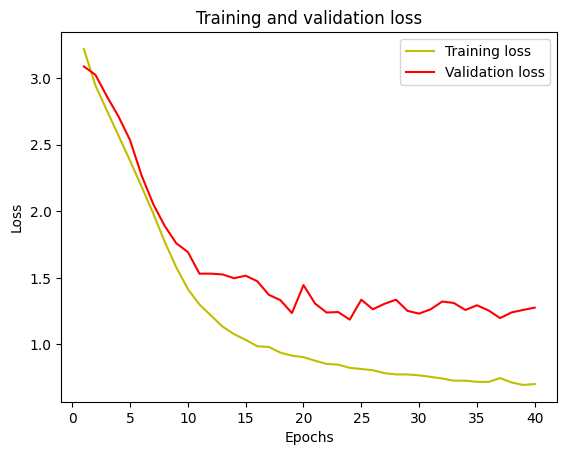

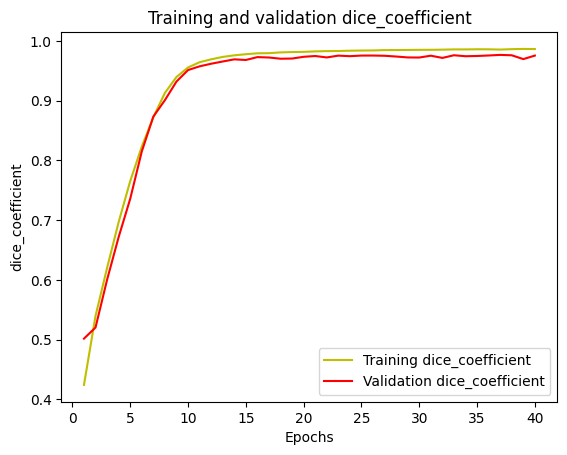

In [56]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['dice_coefficient']
val_acc = history.history['val_dice_coefficient']

plt.plot(epochs, acc, 'y', label='Training dice_coefficient')
plt.plot(epochs, val_acc, 'r', label='Validation dice_coefficient')
plt.title('Training and validation dice_coefficient')
plt.xlabel('Epochs')
plt.ylabel('dice_coefficient')
plt.legend()
plt.show()

In [57]:
from keras.metrics import MeanIoU

batch_size=1 #Check IoU for a batch of images
test_img_datagen = imageLoader(val_img_dir, val_img_list, 
                                val_mask_dir, val_mask_list, batch_size)


test_image_batch, test_mask_batch = test_img_datagen.__next__()

test_mask_batch_argmax = np.argmax(test_mask_batch, axis=4)
test_pred_batch = model.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=4)

n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

1/1 [==============================] - 1s 504ms/step
Mean IoU = 0.58680165


In [71]:

img_num = 88

test_img = np.load("BraTS2020_TrainingData/input_data_128/val/images/image_"+str(img_num)+".npy")

test_mask = np.load("BraTS2020_TrainingData/input_data_128/val/masks/mask_"+str(img_num)+".npy")
test_mask_argmax=np.argmax(test_mask, axis=3)

test_img_input = np.expand_dims(test_img, axis=0)
test_prediction = model.predict(test_img_input)
test_prediction_argmax=np.argmax(test_prediction, axis=4)[0,:,:,:]



1/1 [==============================] - 0s 30ms/step


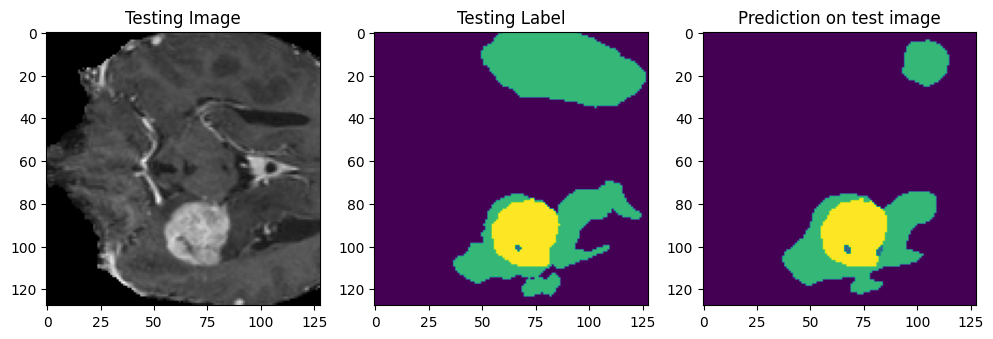

In [76]:
n_slice=random.randint(0, test_prediction_argmax.shape[2])
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,n_slice,1], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask_argmax[:,:,n_slice])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction_argmax[:,:, n_slice])
plt.show()

In [ ]:
#### The model has been trained for very little epochs. make sure to re-train it